
# <span style="color:rgb(213,80,0)">Multi\-shell acquisitions and HYDI without q\-space interpolation</span>

This demo illustrates the basic use of the HYDI module, aimed at the model\-free analysis of multi\-shell data sets.


In [1]:
addpath('..');
setup__DMRIMatlab_toolbox('useparallel',false); % Will be ingnored if you don't have a licensed copy of the parallel toolbox
clear;
close('all');
lambda = Inf; % use generalized cross validation
Rth = 0.05;


















You're running version 1.0 of the toolbox under octave 10.30
Using graphics toolkit: qt






## Load data

Load first your own sutiable multi\-shell dMRI data set, which should include the attenuation signal (DWI over the averaged baseline), the mask to remove the background, the gradients table, and the b\-values for each gradient direction:


In [2]:
tic;
load test_data.mat;
T=toc; % This is always a large piece of data
fprintf(1,'It took %f seconds to load data\n',T);
whos -file test_data.mat; % Check the variables loaded, their kinds, and their sizes





It took 0.767257 seconds to load data

Variables in the file test_data.mat:

variables in scope: test_data.mat

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         atti      101x110x17x256         193402880  single
         bi        256x1                       2048  double
         gi        256x3                       6144  double
         mask      101x110x17                188870  logical

Total is 48540614 elements using 193599942 bytes



## Use only a few slices to accelerate the demo

In [3]:
slc = [4,9,14];
atti = atti(:,:,slc,:);
mask = mask(:,:,slc);
slc = [1,2,3];

## Compute the EAP at a Cartesian lattice

In [4]:
tic;
[eap,dti,lattice,Qx,Qy,Qz,res,lapl,lopt] = atti2hydidsi( atti, gi, bi,'mask', mask, ... % Output dti is ignored in this case
    'tl', 1.0e-7, 'tu', 1-1.0e-7, ... % To avoid outliers
    'lambda', lambda, ... % Laplacian energy penalty. IMPORTANT PARAMETER!
    'tau', 36.5e-3, 'Rth', Rth, ... % The tails are only igored beyond the point where the signal falls to 1% of its value at the origin IMPORTANT PARAMTER!
    'lattice', [], ... % Let the function decide
    'const', true, ... % Actually solve a QP problem to get a positive, unit-mass EAP
    'verbose', true, ... % Plot a fancy progress bar
    'usemex', true, ...
    'maxthreads', 16, ...
    'miters', 10000, 'otol', 1.0e-6, 'stol', 1.0e-6, 'ctol', 1.0e-8 ); % These are the quadprog options
fprintf(1,'It took %1.3f seconds to estimate the EAP\n',toc); % This will be a good while!













It took 22.014 seconds to estimate the EAP


## Compute the standard measures

In [5]:
rtop = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtop');
rtpp = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtpp');
rtap = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtap');
msd  = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'msd');
qmsd = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'qmsd');
mass = hydidsi2index(eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'mass');
[~,~,~,l3,l2,l1] = dti2spectrum( dti, 'mask', mask );
ng   = hydidsi2ng( eap, lattice, Qx, Qy, Qz, l1, l2, l3, 36.5e-3, 'mask', mask );

## Prepare the plots

In [6]:
mapType = 'gray'; % Changing the colormap will trigger the entire demo
switch(mapType)
    case 'high'
        MAP = psychedelia(512);
    case 'gray'
        MAP = gray(512); % B/W colormap
    case 'default'
        MAP = parula(512);
end

## Plot the results

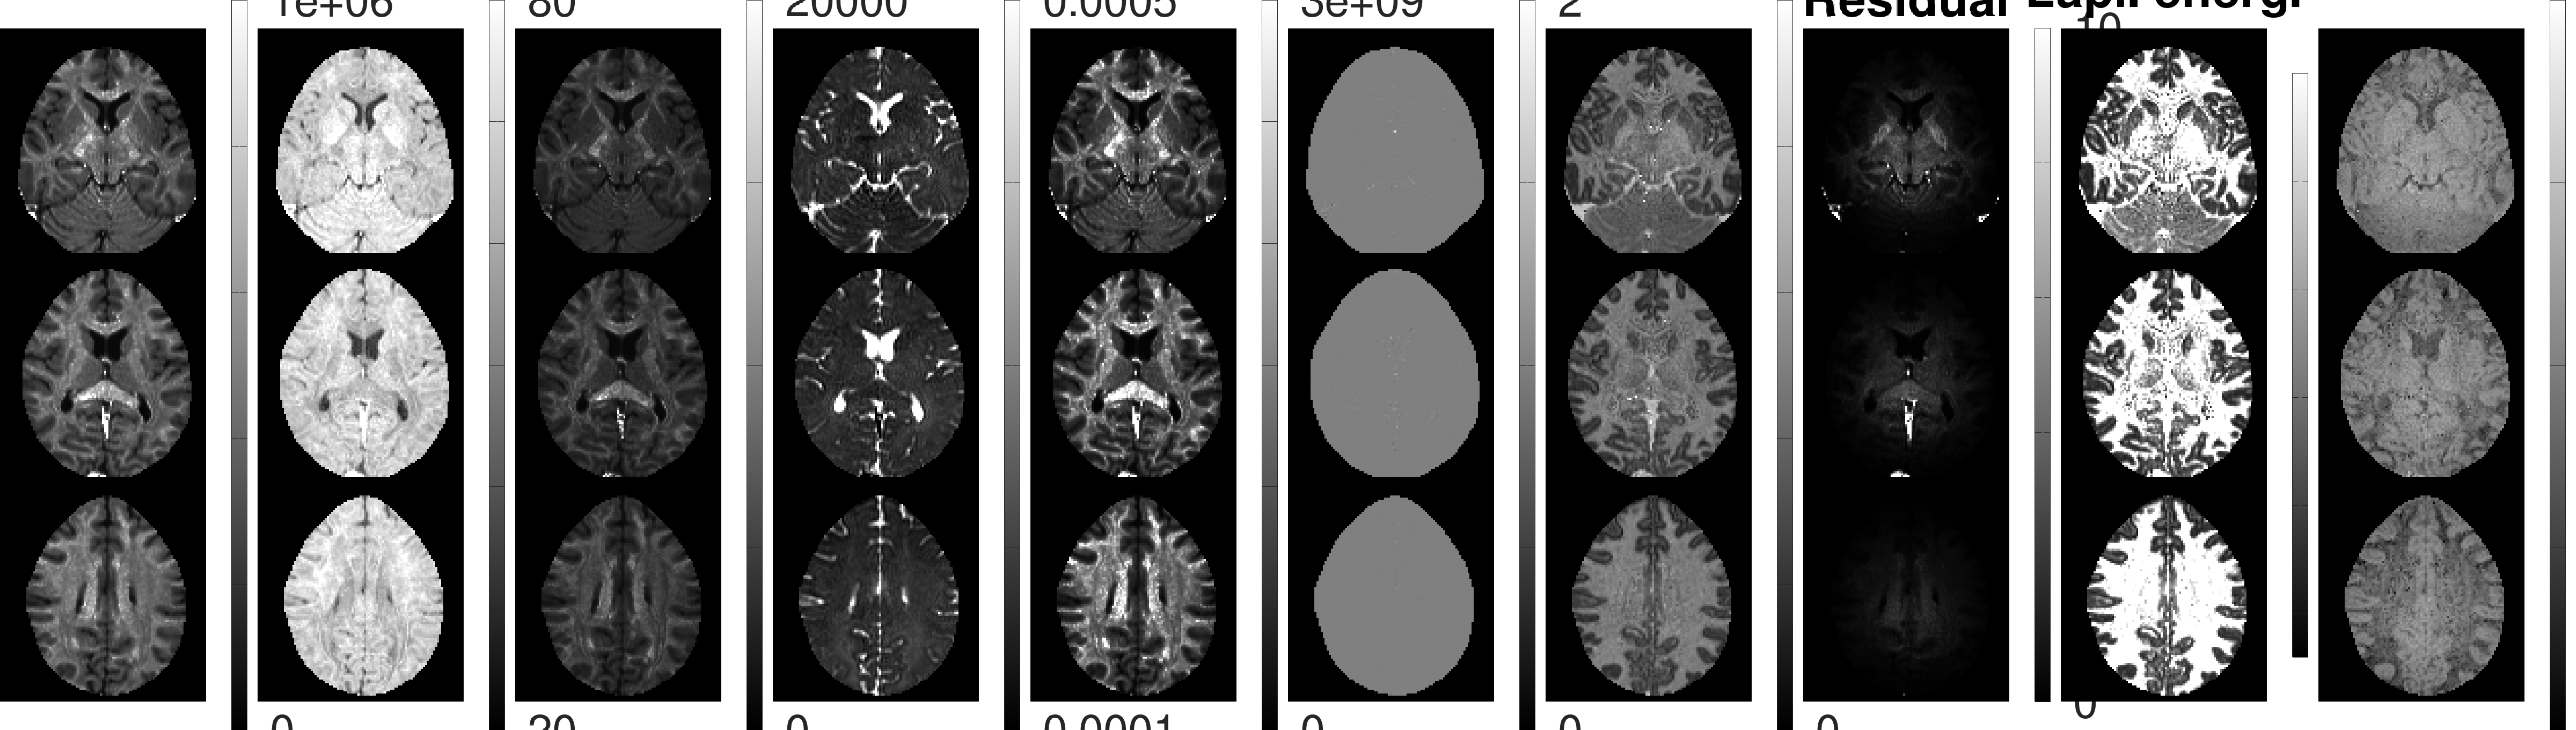

In [7]:
close(figure(1)); % Close previous figures if needed
hf = figure(1);
set(hf,'Name','HYDI indices from multi-shells','Position',[10,10,2400,680]);
R=1; C=10;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtop(:,:,slc(1))';rtop(:,:,slc(2))';rtop(:,:, ...
    slc(3))'],[0,1.0e6]); colormap(MAP); colorbar; title('RTOP');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtpp(:,:,slc(1))';rtpp(:,:,slc(2))';rtpp(:,:, ...
    slc(3))'],[20,80]); colormap(MAP); colorbar; title('RTPP');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtap(:,:,slc(1))';rtap(:,:,slc(2))';rtap(:,:, ...
    slc(3))'],[0,2e4]); colormap(MAP); colorbar; title('RTAP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([msd(:,:,slc(1))';msd(:,:,slc(2))';msd(:,:, ...
    slc(3))'],[1.0e-4,5.0e-4]); colormap(MAP); colorbar; title('MSD');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([qmsd(:,:,slc(1))';qmsd(:,:,slc(2))';qmsd(:,:, ...
    slc(3))'],[0,3e9]); colormap(MAP); colorbar; title('qMSD');
axis('equal');axis('off');axis('tight');
r=1; c=6; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([mass(:,:,slc(1))';mass(:,:,slc(2))';mass(:,:, ...
    slc(3))'],[0,2]); colormap(MAP); colorbar; title('MASS');
axis('equal');axis('off');axis('tight');
r=1; c=7; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([ng(:,:,slc(1))';ng(:,:,slc(2))';ng(:,:, ...
    slc(3))'],[0,1]); colormap(MAP); colorbar; title('NG');
axis('equal');axis('off');axis('tight');
r=1; c=8; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([res(:,:,slc(1))';res(:,:,slc(2))';res(:,:, ...
    slc(3))'],[0,10]); colormap(MAP); colorbar; title('Residual');
r=1; c=9; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([lapl(:,:,slc(1))';lapl(:,:,slc(2))';lapl(:,:, ...
    slc(3))'],[3,30]); colormap(MAP); colorbar; title('Lapl. energ.');
r=1; c=10; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([log10(lopt(:,:,slc(1))');log10(lopt(:,:,slc(2))');log10(lopt(:,:, ...
    slc(3))')],[-4,0]); colormap(MAP); colorbar; title('\lambda');
axis('equal');axis('off');axis('tight');

## DWI reconstruction (and comparison)




It took 27.536 seconds to predict the DWI signal


















































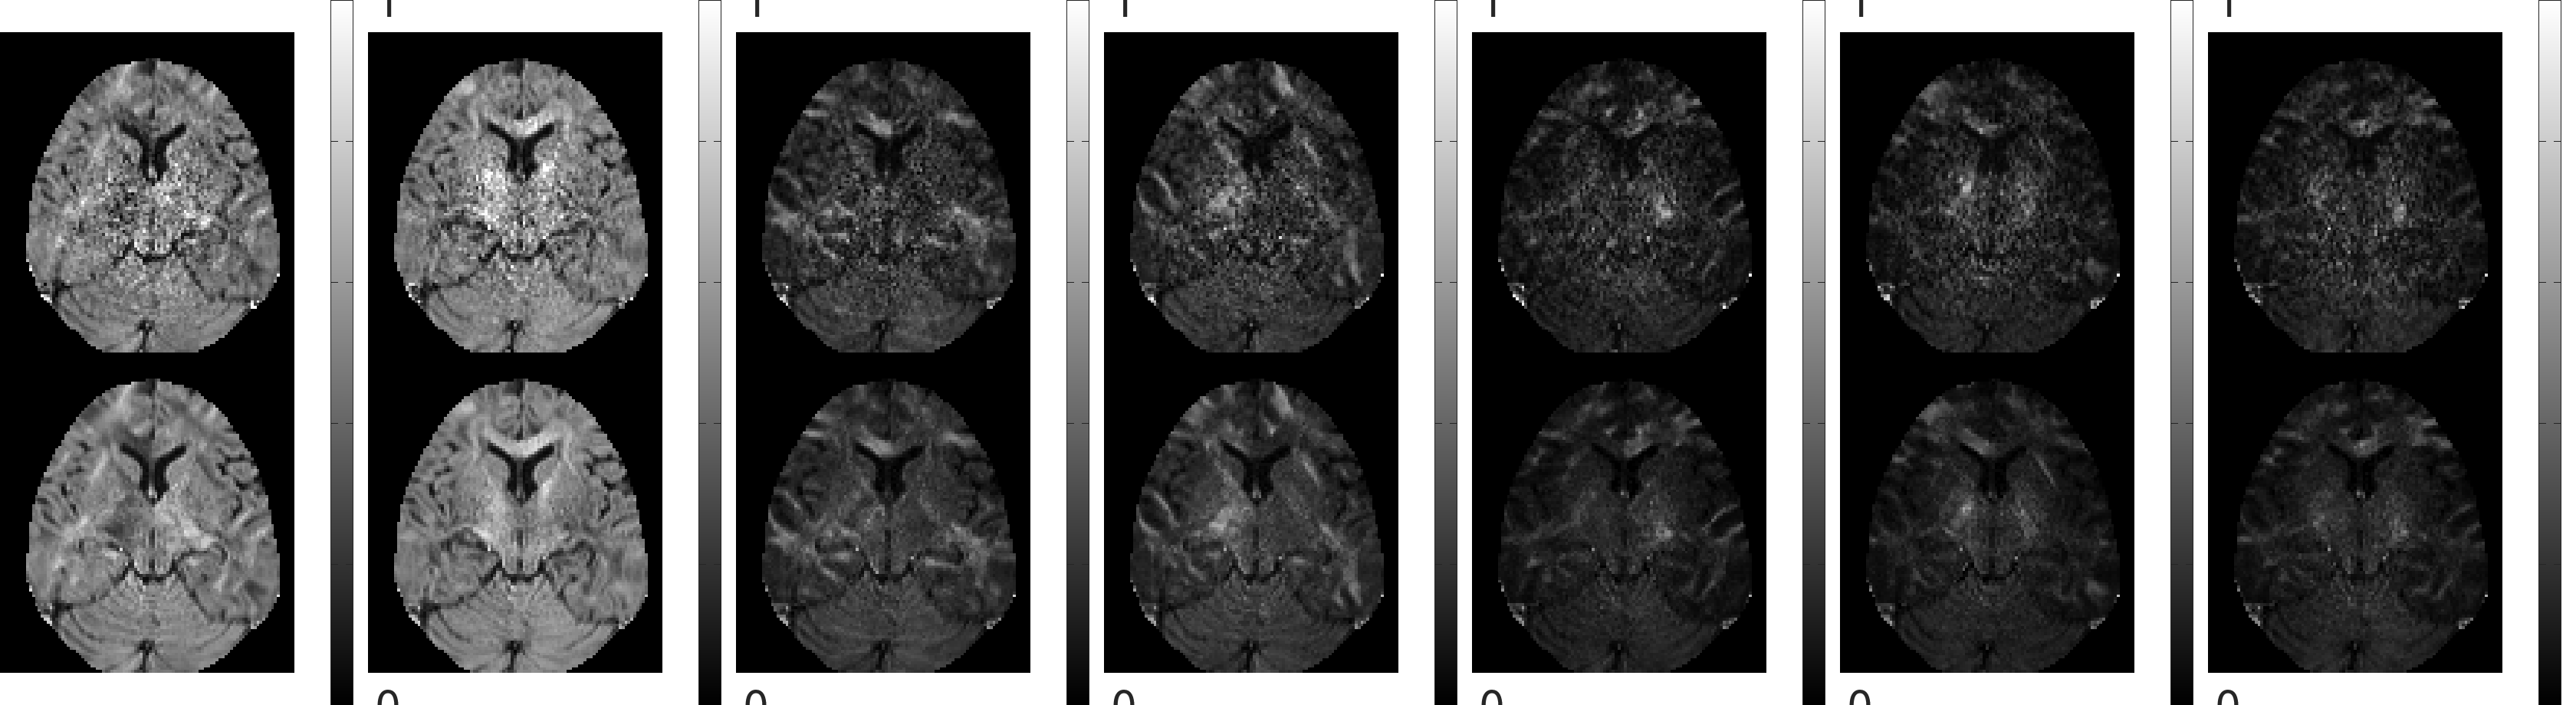

In [8]:
tic;
atti2 = hydidsi2atti( eap, dti, lattice, Qx, Qy, Qz, gi, bi, 'mask', mask, 'tau', 36.5e-3 );
fprintf(1,'It took %1.3f seconds to predict the DWI signal\n',toc);
channels = [13,51,109,121,182,213,247];
close(figure(2)); % Close previous figures if needed
hf = figure(2);
set(hf,'Name','Original DWIs vs. reconstructed DWIs','Position',[10,10,1680,460]);
R=1; C=7;
% --
r=1; c=1; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=2; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=3; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=4; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=5; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=6; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --
r=1; c=7; ch = channels(c);
subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([(double(mask(:,:,slc(1))).*atti(:,:,slc(1),ch))';atti2(:,:,slc(1),ch)'],[0,1.0]);
colormap(gray); colorbar;
axis('equal');axis('off');axis('tight');
% --

## Compute the ODFs

In [9]:
tic;
sh = hydidsi2shodf( eap, dti, Qx, Qy, Qz, lattice, ...
    'L', 8, 'ADC0', 3.0e-3, 'mask', mask, 'rescale', false );
fprintf(1,'It took %1.4f seconds to compute the ODFs\n',toc);
% A simple sanity check...
close(figure(2)); % Close previous figures if needed
hf = figure(2);
set(hf,'Name','Integral of the ODF over the unit sphere','Position',[10,10,2800,1800]);
mass = sh(:,:,:,1)*sqrt(4*pi);
imshow([mass(:,:,slc(1))',mass(:,:,slc(2))',mass(:,:,slc(3))'],[]); colormap(MAP); colorbar; title('Mass');









Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.


Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.
Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to DLASWP.
fatal: caught signal Violación de segmento -- stopping myself...fatal: caught signal 
Violación de segmento -- stopping myself...

/usr/bin/octave-mkl: línea 2: 68996 Violación de segmento     (`core' generado) LD_PRELOAD=/opt/intel/mkl/lib/intel64/libmkl_rt.so:${LD_PRELOAD} /usr/bin/octave "$@"

Restarting kernel...
Done!


[Errno 9] Bad file descriptor


## Prepare ODFs plots

In [ ]:
FA = sqrt(sum(sh(:,:,:,2:6).*sh(:,:,:,2:6),4)./sum(sh(:,:,:,1:6).*sh(:,:,:,1:6),4));
FATH = 0.2;

## Represent the field of ODFs

In [ ]:

close(figure(3)); % Close previous figures if necessary
hf  = figure(3);
set(hf,'Name','ODFs field','Position',[10,10,1400,750],'renderer','Painters');
%---------------------------------------------------------------------------------------------------
contrast = [];
%---------------------------------------------------------------------------------------------------
ha1 = axes('Parent',hf);
set(ha1,'OuterPosition',[-0.02,-0.03,0.25,0.5]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh,[1,mx],[1,110],[sl,sl],'bgimage', 'color', 'bgsh', sh, 'ha', ...
    ha1, 'bgalpha', 1, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3) ); % color-by-orientation half the slice
plotdmri3d(sh,[mx,101],[1,110],[sl,sl],'bgimage', 'fa', 'bgsh', sh, 'ha', ...
    ha1,'bgalpha', 0.9, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    sh, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha1, 'bgimage', 'fa', 'bgsh', ...
    sh, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1.5,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[-1,0,-1]); % Even cooler look
axis('equal');
axis('off');
view(ha1,0,270);
%zoom(1.01);
ha3 = axes('Parent',hf);
set(ha3,'OuterPosition',[-0.6,-0.525,2.2,2.2]);
sl = 3; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'bgimage', 'fa', 'bgsh', sh, 'ha', ...
    ha3,'bgalpha', 0, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh,[mx+2,mx+30],[45,65],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    sh, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
plotdmri3d(sh,[mx+15,mx+30],[65,72],[sl,sl],'bgimage', 'fa', 'bgsh', sh, 'ha', ...
    ha3,'bgalpha', 0, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh,[mx+15,mx+30],[66,72],[sl,sl],'ha',ha3, 'bgimage', 'fa', 'bgsh', ...
    sh, 'bgalpha', 0, 'mask', mask & (FA>FATH), 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'contrast', contrast, 'glyphspc', [1;1;1], 'glyphsc', 1,'glyphscvar', 'ga', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light('Position',[1,0,1]); % Even cooler look
axis('equal');
axis('off');
view(ha3,30,45);
%---------------------------------------------------------------------------------------------------
set(hf,'renderer','Painters');

## Compute the EAP at a Cartesian lattice (with the original Wu's method)

In [ ]:
% To replicate the original Wu's method, one should fix 'fixedq' true,
% 'const' false, and lattice [4;4;4]:
tic;
[eap2,~,lattice2,Qx2,Qy2,Qz2] = atti2wuhydidsi( atti, gi, bi,'mask', mask, ... % Output dti is ignored in this case
    'tl', 1.0e-7, 'tu', 1-1.0e-7, ... % To avoid outliers
    'fixedq', false, ... % Set a fixed bandwidth for all voxels depending just on the maximum b-value acquired
    'tau', 36.5e-3, 'Rth', Rth, ... % The tails are only igored beyond the point where the signal falls to 1% of its value at the origin IMPORTANT PARAMETER!
    'lattice', [], ... % Let the function decide
    'const', false, ... % Re-normalize to get positive, unit mass EAP
    'verbose', true ); % Plot a fancy progress bar
fprintf(1,'It took %1.3f seconds to estimate the EAP\n',toc); % This will be a good while!

## Compute the standard measures (with the original Wu's method)

In [ ]:
rtop2 = wuhydidsi2index(eap2, lattice2, Qx2, Qy2, Qz2, 'mask', mask, 'kind', 'rtop');
rtpp2 = wuhydidsi2index(eap2, lattice2, Qx2, Qy2, Qz2, 'mask', mask, 'kind', 'rtpp');
rtap2 = wuhydidsi2index(eap2, lattice2, Qx2, Qy2, Qz2, 'mask', mask, 'kind', 'rtap');
msd2  = wuhydidsi2index(eap2, lattice2, Qx2, Qy2, Qz2, 'mask', mask, 'kind', 'msd');
mass2 = wuhydidsi2index(eap2, lattice2, Qx2, Qy2, Qz2, 'mask', mask, 'kind', 'mass');

## Plot the results (with the original Wu's method)

In [ ]:
close(figure(4)); % Close previous figures if needed
hf = figure(4);
set(hf,'Name','HYDI indices from multi-shells','Position',[10,10,1200,680]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtop2(:,:,slc(1))';rtop2(:,:,slc(2))';rtop2(:,:, ...
    slc(3))'],[0,1.0e6]); colormap(MAP); colorbar; title('RTOP');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtpp2(:,:,slc(1))';rtpp2(:,:,slc(2))';rtpp2(:,:, ...
    slc(3))'],[20,80]); colormap(MAP); colorbar; title('RTPP');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([rtap2(:,:,slc(1))';rtap2(:,:,slc(2))';rtap2(:,:, ...
    slc(3))'],[0,2e4]); colormap(MAP); colorbar; title('RTAP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([msd2(:,:,slc(1))';msd2(:,:,slc(2))';msd2(:,:, ...
    slc(3))'],[1.0e-4,5.0e-4]); colormap(MAP); colorbar; title('MSD');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imshow([mass2(:,:,slc(1))';mass2(:,:,slc(2))';mass2(:,:, ...
    slc(3))'],[0,2]); colormap(MAP); colorbar; title('MASS');
axis('equal');axis('off');axis('tight');